In [1]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import re
import json
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import get_session_name_from_path, plot_keypoint_confidence_analysis


In [5]:

def generate_tongue_dfs(predictions_csv_path: Path, data_root: Path, tolerance=0.01):
    """
    Runs the full pipeline for one session and returns the NWB object, 
    annotated tongue kinematics, and aggregated tongue movements.

    Parameters
    ----------
    predictions_csv_path : Path
        Path to the predictions CSV (LP_csv).
    data_root : Path
        Root folder containing behavior_<…> session subfolders.
    tolerance : float, optional
        Lick-kinematics matching tolerance (default 0.01).

    Returns
    -------
    tuple : (nwb, tongue_kin, tongue_movs)
        nwb: NWBFile object with annotated licks/trials added
        tongue_kin: frame-level annotated tongue kinematics (DataFrame)
        tongue_movs: movement-level aggregated tongue movements (DataFrame)
    """
    # === Imports inside so function is self-contained ===
    from aind_dynamic_foraging_behavior_video_analysis.kinematics.kinematics_nwb_utils import get_nwb_file
    from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import (
        load_keypoints_from_csv, find_behavior_videos_folder,
        integrate_keypoints_with_video_time, mask_keypoint_data,
        kinematics_filter, segment_movements_trimnans,
        annotate_trials_in_kinematics, annotate_licks_in_kinematics,
        assign_movements_to_licks, aggregate_tongue_movements,
        add_lick_metadata_to_movements, get_session_name_from_path
    )
    import aind_dynamic_foraging_data_utils.nwb_utils as nwb_utils
    from aind_dynamic_foraging_basic_analysis.licks import annotation

    # === 1) Session detection ===
    lp_csv = predictions_csv_path
    session_id = get_session_name_from_path(str(lp_csv))
    print(f"\n=== Generating tongue data for session: {session_id} ===")
    print(f"Predictions CSV: {lp_csv}")

    # === 2) Load keypoints ===
    kps = load_keypoints_from_csv(str(lp_csv))
    print(f"Loaded keypoints: {len(kps)} raw dataframes")

    # === 3) Locate synced video CSV ===
    videos_folder = find_behavior_videos_folder(str(data_root / session_id))
    if videos_folder is None:
        raise FileNotFoundError(f"Videos folder not found for session {session_id}")
    video_csv = Path(videos_folder) / "bottom_camera.csv"
    if not video_csv.exists():
        raise FileNotFoundError(f"Expected video CSV at {video_csv}")
    print(f"Found video CSV: {video_csv}")

    # === 4) Sync keypoints to video time ===
    kps_trim, _ = integrate_keypoints_with_video_time(str(video_csv), kps)
    print(f"Synced keypoints")

    # === 5) Tongue movement segmentation ===
    tongue_masked = mask_keypoint_data(kps_trim, 'tongue_tip_center', confidence_threshold=0.90)
    tongue_filtered = kinematics_filter(tongue_masked, cutoff_freq=50, filter_order=4, filter_kind='cubic')
    tongue_seg = segment_movements_trimnans(tongue_filtered, max_dropped_frames=10)
    print(f"Segmented {tongue_seg['movement_id'].nunique()} unique movements")

    # === 6) Load NWB and annotate ===
    nwb = get_nwb_file(session_id)
    nwb.df_events = nwb_utils.create_events_df(nwb)
    nwb.df_trials = nwb_utils.create_df_trials(nwb)
    nwb.df_licks = annotation.annotate_licks(nwb)
    print(f"NWB load: {len(nwb.df_trials)} trials, {len(nwb.df_licks)} licks")

    tongue_annot = annotate_trials_in_kinematics(tongue_seg, nwb.df_trials)
    tongue_kin = annotate_licks_in_kinematics(tongue_annot, nwb.df_licks, tolerance=tolerance)
    nwb.df_licks = assign_movements_to_licks(tongue_kin, nwb.df_licks)
    print("Annotated kinematics with trials & licks")

    # === 7) Aggregate movements ===
    tongue_movs = aggregate_tongue_movements(tongue_kin, kps_trim)
    tongue_movs = add_lick_metadata_to_movements(
        tongue_movs, nwb.df_licks, fields=['cue_response','rewarded','event']
    )
    print(f"Aggregated movements DF shape: {tongue_movs.shape}")

    return nwb, tongue_kin, tongue_movs, kps_trim


In [6]:
def select_percentile_movements(
    df: pd.DataFrame,
    metric_col: str,
    percentiles: list = [0, 0.25, 0.5, 0.75, 1.0]
) -> pd.DataFrame:
    """
    Return movement_ids and corresponding metric values at specified percentiles.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'movement_id' and the metric column.
    metric_col : str
        Name of the numeric column to sort and index into.
    percentiles : list of float
        Values between 0 and 1 for desired percentiles.

    Returns
    -------
    pd.DataFrame
        Columns: ['movement_id', metric_col, 'percentile']
    """
    if metric_col not in df.columns:
        raise ValueError(f"Column '{metric_col}' not found")
    series = df[['movement_id', metric_col]].dropna()
    if not pd.api.types.is_numeric_dtype(series[metric_col]):
        raise ValueError(f"Column '{metric_col}' must be numeric")
    if any(p < 0 or p > 1 for p in percentiles):
        raise ValueError("Percentiles must be in [0, 1]")

    sorted_df = series.sort_values(metric_col).reset_index(drop=True)
    N = len(sorted_df)
    if N == 0:
        return pd.DataFrame(columns=['movement_id', metric_col, 'percentile'])

    rows = []
    for p in percentiles:
        idx = int(round(p * (N - 1)))
        rows.append({
            'movement_id': int(sorted_df.loc[idx, 'movement_id']),
            metric_col: sorted_df.loc[idx, metric_col],
            'percentile': p
        })

    return pd.DataFrame(rows)

def plot_movement_tiles_scatter(
    tongue_segmented: pd.DataFrame,
    movement_ids: list,
    x_col: str,
    y_col: str,
    labels: list = None,
    color: str = 'gray',
    s: int = 5,
    title: str = None,
    return_fig=False
):
    """
    Plot scatter of any two kinematic columns for a given list of movement_ids.

    Parameters
    ----------
    tongue_segmented : pd.DataFrame
        Frame-level data with at least 'movement_id', x_col, y_col.
    movement_ids : list
        Movement IDs to plot (one subplot per movement).
    x_col : str
        Column in tongue_segmented to plot on x-axis.
    y_col : str
        Column in tongue_segmented to plot on y-axis.
    labels : list, optional
        List of strings or values to annotate each subplot (same length as movement_ids).
    color : str
        Point color for scatter.
    s : int
        Point size for scatter.
    title : str
        Title of figure
    """
    n = len(movement_ids)
    fig, axes = plt.subplots(1, n, figsize=(n * 2, 2), sharex=True, sharey=True)
    if n == 1:
        axes = [axes]

    # Global axis limits
    all_x, all_y = [], []
    for mid in movement_ids:
        df = tongue_segmented[tongue_segmented['movement_id'] == mid]
        df = df[[x_col, y_col]].dropna()
        all_x.extend(df[x_col])
        all_y.extend(df[y_col])
    if not all_x:
        raise RuntimeError("No valid movements found to plot.")
    xlim = (min(all_x), max(all_x))
    ylim = (min(all_y), max(all_y))

    for i, (ax, mid) in enumerate(zip(axes, movement_ids)):
        df = tongue_segmented[tongue_segmented['movement_id'] == mid]
        df = df[[x_col, y_col]].dropna()

        if len(df) < 1:
            ax.scatter([0], [0], s=10, color='black')
        else:
            ax.scatter(df[x_col], df[y_col], s=s, color=color)

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xlabel(x_col, fontsize=7)
        if ax == axes[0]:
            ax.set_ylabel(y_col, fontsize=7)

        if labels is not None:
            ax.set_title(str(labels[i]), fontsize=8)
    
    if title:
        plt.suptitle(title, fontsize=10)
    else:
        plt.suptitle(f"{y_col} vs {x_col}", fontsize=10)
    
    # plt.suptitle(f"{y_col} vs {x_col}", fontsize=10)
    plt.tight_layout()
    if return_fig:
        return fig
    else:
        plt.show()
    


In [7]:

def analyze_tongue_movement_quality(
    kps_raw: dict,
    tongue_kins: pd.DataFrame,
    tongue_movs: pd.DataFrame,
    nwb,
    save_dir: str,
    percentiles: list = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0],
    pred_csv=None 
):
    """
    Analyze and visualize tongue movement quality for a single session.

    Saves figures and key summary stats in a session-specific folder.

    Parameters
    ----------
    tongue_kins : pd.DataFrame
        Frame-level kinematics data.
    tongue_movs : pd.DataFrame
        Movement-level kinematics data (one row per movement).
    nwb : NWB object with df_licks.
    pred_csv : str
        Path to the prediction CSV (used to infer session name).
    save_dir : str
        Directory where results will be saved.
    percentiles : list
        Percentiles to sample for movement quality plots.
    """

    # ----------------
    # Setup & Folders
    # ----------------
    os.makedirs(save_dir, exist_ok=True)
    session_id = os.path.basename(save_dir)

    print(f"Analyzing session: {session_id}")
    
    # ----------------
    # Confidence figure
    # ----------------
    keypt = 'tongue_tip_center'  # Example, can be parameterized in wrapper
    plot_keypoint_confidence_analysis(
        keypoint_dfs=kps_raw,
        keypt=keypt,
        save_dir=save_dir,
        save_figures=True
        )
        
    # ----------------
    # Lick Coverage
    # ----------------
    total_licks = len(nwb.df_licks)
    with_mov = nwb.df_licks['nearest_movement_id'].notna().sum()
    coverage_pct = 100 * with_mov / total_licks if total_licks else np.nan

    lick_movs = tongue_movs[tongue_movs['has_lick']]
    lick_times = nwb.df_licks['timestamps']
    has_mov = nwb.df_licks['nearest_movement_id'].notna()
    covered_times = lick_times[has_mov]
    missed_times = lick_times[~has_mov]

    # ----------------
    # Lick Coverage Figure
    # ----------------
    fig = plt.figure(constrained_layout=True, figsize=(14, 8))
    parent_gs = fig.add_gridspec(2, 1, height_ratios=[1, 1])
    gs_top = parent_gs[0].subgridspec(1, 3, width_ratios=[0.5, 6, 3])
    gs_bottom = parent_gs[1].subgridspec(1, 3)

    ax_cov = fig.add_subplot(gs_top[0, 0])
    ax_raster = fig.add_subplot(gs_top[0, 1])
    ax_scat = fig.add_subplot(gs_top[0, 2])
    ax_h0 = fig.add_subplot(gs_bottom[0, 0])
    ax_h1 = fig.add_subplot(gs_bottom[0, 1])
    ax_h2 = fig.add_subplot(gs_bottom[0, 2])

    # --- Coverage Bar ---
    n_missed = total_licks - with_mov
    ax_cov.bar(0, coverage_pct, color='green', label=f'Covered (n={with_mov})')
    ax_cov.bar(0, 100 - coverage_pct, bottom=coverage_pct,
               color='red', label=f'Missed (n={n_missed})')
    ax_cov.set_ylim(0, 100)
    ax_cov.set_xticks([])
    ax_cov.set_title("Lick Coverage (%)", fontsize=10)
    ax_cov.legend(fontsize=7, loc='lower center')

    # --- Raster ---
    ax_raster.eventplot(
        [covered_times, missed_times],
        lineoffsets=[1, 0], linelengths=0.8,
        colors=['green', 'red']
    )
    ax_raster.set_yticks([1, 0])
    ax_raster.set_yticklabels(['Covered', 'Missed'])
    ax_raster.set_xlabel('Time in session (s)')
    ax_raster.set_title('Lick coverage over session')

    # --- Scatter ---
    ax_scat.scatter(lick_movs['duration'], lick_movs['dropped_frames_pct'],
                    alpha=0.05, edgecolor='k')
    ax_scat.set_xlabel('Duration (s)')
    ax_scat.set_ylabel('Dropped Frame %')
    ax_scat.set_title('Duration vs Drop%')

    # --- Histograms ---
    ax_h0.hist(lick_movs['n_datapoints'], bins=30)
    ax_h0.set(title='Datapoints')
    ax_h1.hist(lick_movs['duration'], bins=30)
    ax_h1.set(title='Duration')
    ax_h2.hist(lick_movs['dropped_frames_pct'], bins=30)
    ax_h2.set(title='Dropped %')

    plt.suptitle(f'{session_id}', y=1.02)
    fig.savefig(os.path.join(save_dir, "lick_coverage_summary.png"), dpi=150)
    plt.close(fig)

    # ----------------
    # Movement Percentile Plots
    # ----------------
    tongue_kins['time_in_movement'] = (
        tongue_kins['time'] -
        tongue_kins.groupby('movement_id')['time'].transform('first')
    )

    percentile_results = {}
    for metric_col in ['dropped_frames_n', 'duration']:
        sel = select_percentile_movements(tongue_movs, metric_col=metric_col, percentiles=percentiles)
        labels = [f"{int(p*100)}%ile: {val:.2f}" 
                  for p, val in zip(sel['percentile'], sel[metric_col])]
        percentile_results[metric_col] = dict(zip(sel['percentile'], sel[metric_col]))


        fig = plot_movement_tiles_scatter(
            tongue_segmented=tongue_kins,
            movement_ids=sel['movement_id'].tolist(),
            x_col='time_in_movement',
            y_col='x',
            labels=labels,
            color='gray',
            title=metric_col,
            return_fig=True
        )
        fig.savefig(os.path.join(save_dir, f"{metric_col}_tiles.png"), dpi=150)
        plt.close(fig)

    # ----------------
    # Save Everything to JSON
    # ----------------
    results_dict = {
        "session_id": os.path.basename(save_dir),
        "pred_csv": str(pred_csv) if pred_csv else None,
        "total_licks": int(total_licks),
        "licks_with_movement": int(with_mov),
        "coverage_pct": float(coverage_pct),
        "percentiles": percentile_results
    }

    with open(os.path.join(save_dir, "tongue_quality_stats.json"), "w") as f:
        json.dump(results_dict, f, indent=2)

    print(f"✅ Finished analysis for {session_id}. Results saved to {save_dir}")


In [6]:
# Path to the predictions CSV (from the processed folder)
pred_csv = Path("/root/capsule/data/behavior_751004_2024-12-23_14-19-57_processed_2025-07-10_06-34-56/pred_outputs/video_preds/bottom_camera_predictions.csv")

# Root folder where the raw behavior_<...> session folders live
data_root = Path("/root/capsule/data")

# save dir
save_root = '/root/capsule/scratch/session_analysis/'

nwb, tongue_kins, tongue_movs, kps_raw = generate_tongue_dfs(pred_csv, data_root)


=== Generating tongue data for session: behavior_751004_2024-12-23_14-19-57 ===
Predictions CSV: /root/capsule/data/behavior_751004_2024-12-23_14-19-57_processed_2025-07-10_06-34-56/pred_outputs/video_preds/bottom_camera_predictions.csv
keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Loaded keypoints: 11 raw dataframes
Found video CSV: /root/capsule/data/behavior_751004_2024-12-23_14-19-57/behavior-videos/bottom_camera.csv
Video QC: Frame numbers are sequential with no gaps.
Video QC: Timing differences are within expected range.
keypoint_df trimmed from 3338382 to 3338381
Synced keypoints
Segmented 5817 unique movements
NWB file not found for 751004 on 2024-12-23. Generating it now...
Generated NWB file: /root/capsule/scratch/behavior_751004_2024-12-23_14-19-57/751004_2024-12-23_14-20-03.nwb
Timestamps are adjusted such that `_in_session` ti

/opt/conda/lib/python3.9/site-packages/aind_dynamic_foraging_data_utils/nwb_utils.py:506: UserWarning: Reward before choice time.                 This is likely due to manual rewards not being recorded in sessions from 2024
  warnings.warn("Reward before choice time. \


NWB load: 579 trials, 5397 licks
Annotated kinematics with trials & licks
Aggregated movements DF shape: (5817, 37)


Analyzing session: behavior_751004_2024-12-23_14-19-57


✅ Finished analysis for behavior_751004_2024-12-23_14-19-57. Results saved to /root/capsule/scratch/session_analysis/behavior_751004_2024-12-23_14-19-57


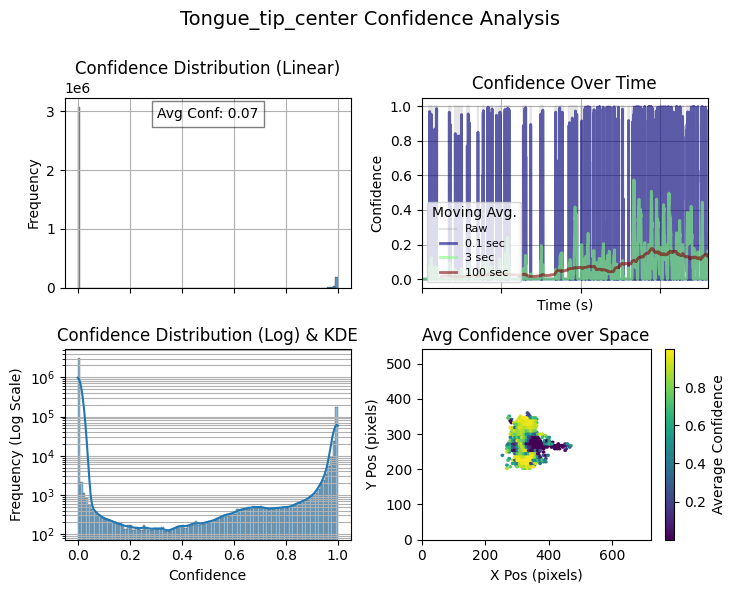

In [8]:


# ----------------
# Generate Session Folder Name
# ----------------
session_id = get_session_name_from_path(str(pred_csv))
session_save_dir = os.path.join(save_root, session_id)
os.makedirs(session_save_dir, exist_ok=True)

# ----------------
# Save Intermediate Data (Parquet)
# ----------------
intermediate_folder = os.path.join(session_save_dir, "intermediate_data")
os.makedirs(intermediate_folder, exist_ok=True)

# Save tongue_kins and tongue_movs
tongue_kins.to_parquet(os.path.join(intermediate_folder, "tongue_kins.parquet"))
tongue_movs.to_parquet(os.path.join(intermediate_folder, "tongue_movs.parquet"))

# Save each df in kps_raw dict
for key, df in kps_raw.items():
    df.to_parquet(os.path.join(intermediate_folder, f"kps_raw_{key}.parquet"))

# Save selected NWB dfs
nwb.df_licks.to_parquet(os.path.join(intermediate_folder, "nwb_df_licks.parquet"))
nwb.df_trials.to_parquet(os.path.join(intermediate_folder, "nwb_df_trials.parquet"))
nwb.df_events.to_parquet(os.path.join(intermediate_folder, "nwb_df_events.parquet"))

# ----------------
# Run Analysis
# ----------------
analyze_tongue_movement_quality(
    kps_raw=kps_raw,
    tongue_kins=tongue_kins,
    tongue_movs=tongue_movs,
    nwb=nwb,
    save_dir=session_save_dir,
    percentiles=[0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0],
    pred_csv=pred_csv
)


In [8]:
def run_batch_analysis(pred_csv_list, data_root, save_root, percentiles=None):
    """
    Run analysis for multiple sessions in batch.

    Parameters
    ----------
    pred_csv_list : list of str or Path
        List of prediction CSV paths (one per session).
    data_root : str or Path
        Root folder where behavior_<...> session folders live.
    save_root : str or Path
        Root folder to save all analysis outputs.
    percentiles : list, optional
        Percentiles for movement quality plots (default: [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]).
    """
    percentiles = percentiles or [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
    save_root = Path(save_root)
    save_root.mkdir(parents=True, exist_ok=True)

    error_log = []

    for pred_csv in pred_csv_list:
        pred_csv = Path(pred_csv)
        session_id = get_session_name_from_path(str(pred_csv))

        print(f"\n🔹 Starting analysis for: {session_id}")
        session_save_dir = os.path.join(save_root, session_id)
        os.makedirs(session_save_dir, exist_ok=True)

        try:
            # ---- 1) Generate DFs ----
            nwb, tongue_kins, tongue_movs, kps_raw = generate_tongue_dfs(pred_csv, data_root)

            # ---- 1a) Save intermediate data ----
            intermediate_folder = os.path.join(session_save_dir, "intermediate_data")
            os.makedirs(intermediate_folder, exist_ok=True)

            # Save tongue_kins and tongue_movs
            tongue_kins.to_parquet(os.path.join(intermediate_folder, "tongue_kins.parquet"))
            tongue_movs.to_parquet(os.path.join(intermediate_folder, "tongue_movs.parquet"))

            # Save each df in kps_raw dict
            for key, df in kps_raw.items():
                df.to_parquet(os.path.join(intermediate_folder, f"kps_raw_{key}.parquet"))

            # Save selected NWB dfs
            nwb.df_licks.to_parquet(os.path.join(intermediate_folder, "nwb_df_licks.parquet"))
            nwb.df_trials.to_parquet(os.path.join(intermediate_folder, "nwb_df_trials.parquet"))
            nwb.df_events.to_parquet(os.path.join(intermediate_folder, "nwb_df_events.parquet"))

            # ---- 2) Run analysis ----
            analyze_tongue_movement_quality(
                kps_raw=kps_raw,
                tongue_kins=tongue_kins,
                tongue_movs=tongue_movs,
                nwb=nwb,
                save_dir=session_save_dir,
                percentiles=percentiles,
                pred_csv=pred_csv
            )

        except Exception as e:
            error_msg = f"❌ Error in {session_id}: {repr(e)}"
            print(error_msg)
            error_log.append(error_msg)
            continue  # Move to the next session

    # ---- Print & Save Error Log ----
    if error_log:
        log_file = save_root / "batch_error_log.txt"
        with open(log_file, "w") as f:
            f.write("\n".join(error_log))
        print(f"\n⚠️ Completed with errors. See log: {log_file}")
    else:
        print("\n✅ Batch analysis completed successfully for all sessions!")



🔹 Starting analysis for: behavior_716325_2024-05-31_10-31-14

=== Generating tongue data for session: behavior_716325_2024-05-31_10-31-14 ===
Predictions CSV: /root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_716325_2024-05-31_10-31-14/bottom_camera.csv
keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Loaded keypoints: 11 raw dataframes
Found video CSV: /root/capsule/data/behavior_716325_2024-05-31_10-31-14/behavior-videos/bottom_camera.csv
Video QC: Frame numbers are sequential with no gaps.
Video QC: Timing differences are within expected range.
keypoint_df trimmed from 2689719 to 2689718
Synced keypoints
Segmented 7258 unique movements
Loading NWB from /root/capsule/data/foraging_nwb_bonsai/716325_2024-05-31_10-31-14.nwb


/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
NWB load: 586 trials, 5846 licks
Annotated kinematics with trials & licks
Aggregated movements DF shape: (7258, 37)
Analyzing session: behavior_716325_2024-05-31_10-31-14
✅ Finished analysis for behavior_716325_2024-05-31_10-31-14. Results saved to /root/capsule/scratch/session_analysis_in_distribution/behavior_716325_2024-05-31_10-31-14

🔹 Starting analysis for: behavior_717121_2024-06-15_10-00-58

=== Generating tongue data for session: behavior_717121_2024-06-15_10-00-58 ===
Predictions CSV: /root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_717121_2024-06-15_10-00-58/bottom_camera.csv
keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Loaded keypoints: 11 r

/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
NWB load: 571 trials, 6340 licks
Annotated kinematics with trials & licks
Aggregated movements DF shape: (6990, 37)
Analyzing session: behavior_717121_2024-06-15_10-00-58
✅ Finished analysis for behavior_717121_2024-06-15_10-00-58. Results saved to /root/capsule/scratch/session_analysis_in_distribution/behavior_717121_2024-06-15_10-00-58

🔹 Starting analysis for: behavior_717259_2024-06-28_11-17-19

=== Generating tongue data for session: behavior_717259_2024-06-28_11-17-19 ===
Predictions CSV: /root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_717259_2024-06-28_11-17-19/bottom_camera.csv
keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Loaded keypoints: 11 r

/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
NWB load: 528 trials, 6166 licks
Annotated kinematics with trials & licks
Aggregated movements DF shape: (6361, 37)
Analyzing session: behavior_717259_2024-06-28_11-17-19
✅ Finished analysis for behavior_717259_2024-06-28_11-17-19. Results saved to /root/capsule/scratch/session_analysis_in_distribution/behavior_717259_2024-06-28_11-17-19

🔹 Starting analysis for: behavior_717263_2024-07-24_10-40-05

=== Generating tongue data for session: behavior_717263_2024-07-24_10-40-05 ===
Predictions CSV: /root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_717263_2024-07-24_10-40-05/bottom_camera.csv
keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Loaded keypoints: 11 r

/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue


/opt/conda/lib/python3.9/site-packages/aind_dynamic_foraging_data_utils/nwb_utils.py:506: UserWarning: Reward before choice time.                 This is likely due to manual rewards not being recorded in sessions from 2024
  warnings.warn("Reward before choice time. \


NWB load: 521 trials, 5092 licks
Annotated kinematics with trials & licks
Aggregated movements DF shape: (5308, 37)
Analyzing session: behavior_717263_2024-07-24_10-40-05
✅ Finished analysis for behavior_717263_2024-07-24_10-40-05. Results saved to /root/capsule/scratch/session_analysis_in_distribution/behavior_717263_2024-07-24_10-40-05

🔹 Starting analysis for: behavior_751004_2024-12-20_13-26-07

=== Generating tongue data for session: behavior_751004_2024-12-20_13-26-07 ===
Predictions CSV: /root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_751004_2024-12-20_13-26-07/bottom_camera.csv
keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Loaded keypoints: 11 raw dataframes
Found video CSV: /root/capsule/data/behavior_751004_2024-12-20_13-26-07/behavior-videos/bottom_camera.csv
Video QC: Frame numbers are sequential with no gap

/opt/conda/lib/python3.9/site-packages/aind_dynamic_foraging_data_utils/nwb_utils.py:506: UserWarning: Reward before choice time.                 This is likely due to manual rewards not being recorded in sessions from 2024
  warnings.warn("Reward before choice time. \


NWB load: 517 trials, 5269 licks
Annotated kinematics with trials & licks
Aggregated movements DF shape: (6113, 37)
Analyzing session: behavior_751004_2024-12-20_13-26-07
✅ Finished analysis for behavior_751004_2024-12-20_13-26-07. Results saved to /root/capsule/scratch/session_analysis_in_distribution/behavior_751004_2024-12-20_13-26-07

🔹 Starting analysis for: behavior_751004_2024-12-21_13-28-24

=== Generating tongue data for session: behavior_751004_2024-12-21_13-28-24 ===
Predictions CSV: /root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_751004_2024-12-21_13-28-24/bottom_camera.csv
keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Loaded keypoints: 11 raw dataframes
Found video CSV: /root/capsule/data/behavior_751004_2024-12-21_13-28-24/behavior-videos/bottom_camera.csv
Video QC: Frame numbers are sequential with no gap

/opt/conda/lib/python3.9/site-packages/aind_dynamic_foraging_data_utils/nwb_utils.py:506: UserWarning: Reward before choice time.                 This is likely due to manual rewards not being recorded in sessions from 2024
  warnings.warn("Reward before choice time. \


NWB load: 582 trials, 5782 licks
Annotated kinematics with trials & licks
Aggregated movements DF shape: (6164, 37)
Analyzing session: behavior_751004_2024-12-21_13-28-24
✅ Finished analysis for behavior_751004_2024-12-21_13-28-24. Results saved to /root/capsule/scratch/session_analysis_in_distribution/behavior_751004_2024-12-21_13-28-24

🔹 Starting analysis for: behavior_751004_2024-12-22_13-09-11

=== Generating tongue data for session: behavior_751004_2024-12-22_13-09-11 ===
Predictions CSV: /root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_751004_2024-12-22_13-09-11/bottom_camera.csv
keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Loaded keypoints: 11 raw dataframes
Found video CSV: /root/capsule/data/behavior_751004_2024-12-22_13-09-11/behavior-videos/bottom_camera.csv
Video QC: Frame numbers are sequential with no gap

/opt/conda/lib/python3.9/site-packages/aind_dynamic_foraging_data_utils/nwb_utils.py:506: UserWarning: Reward before choice time.                 This is likely due to manual rewards not being recorded in sessions from 2024
  warnings.warn("Reward before choice time. \


NWB load: 638 trials, 7135 licks
Annotated kinematics with trials & licks
Aggregated movements DF shape: (7661, 37)
Analyzing session: behavior_751004_2024-12-22_13-09-11
✅ Finished analysis for behavior_751004_2024-12-22_13-09-11. Results saved to /root/capsule/scratch/session_analysis_in_distribution/behavior_751004_2024-12-22_13-09-11

🔹 Starting analysis for: behavior_751004_2024-12-23_14-19-57

=== Generating tongue data for session: behavior_751004_2024-12-23_14-19-57 ===
Predictions CSV: /root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_751004_2024-12-23_14-19-57/bottom_camera.csv
keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Loaded keypoints: 11 raw dataframes
Found video CSV: /root/capsule/data/behavior_751004_2024-12-23_14-19-57/behavior-videos/bottom_camera.csv
Video QC: Frame numbers are sequential with no gap

/opt/conda/lib/python3.9/site-packages/aind_dynamic_foraging_data_utils/nwb_utils.py:506: UserWarning: Reward before choice time.                 This is likely due to manual rewards not being recorded in sessions from 2024
  warnings.warn("Reward before choice time. \


NWB load: 579 trials, 5397 licks
Annotated kinematics with trials & licks
Aggregated movements DF shape: (5863, 37)
Analyzing session: behavior_751004_2024-12-23_14-19-57
✅ Finished analysis for behavior_751004_2024-12-23_14-19-57. Results saved to /root/capsule/scratch/session_analysis_in_distribution/behavior_751004_2024-12-23_14-19-57

✅ Batch analysis completed successfully for all sessions!


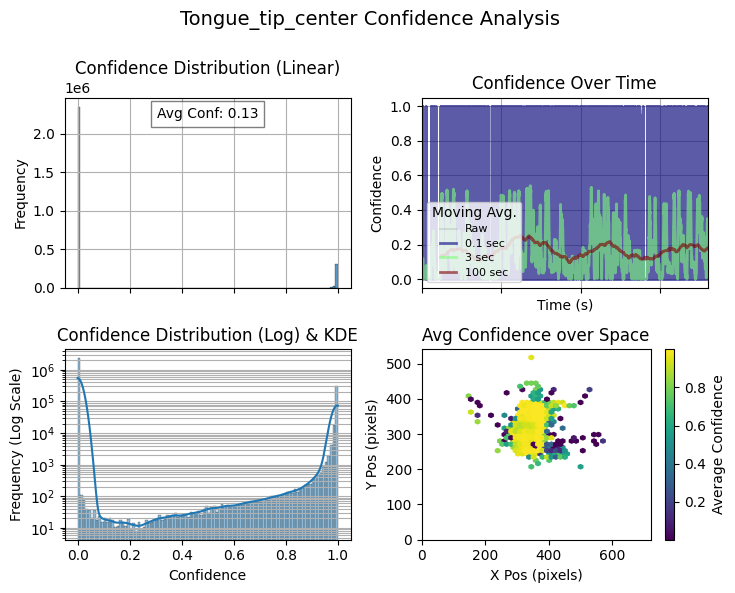

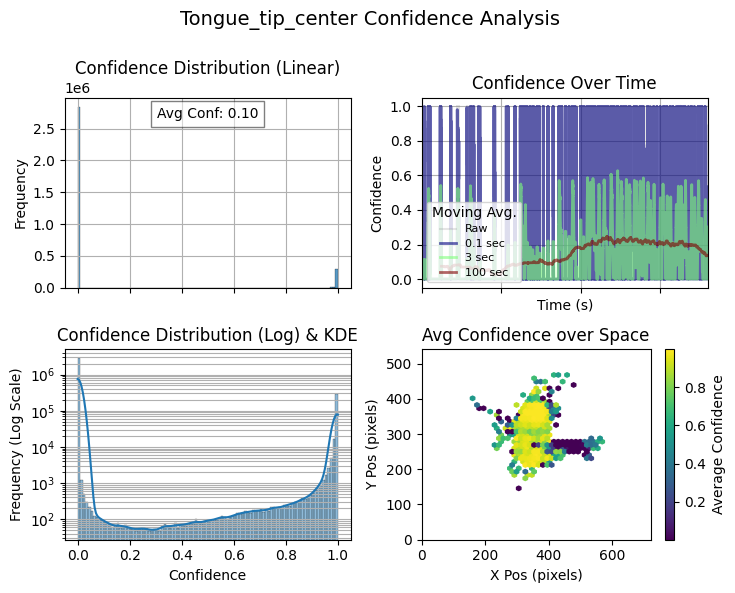

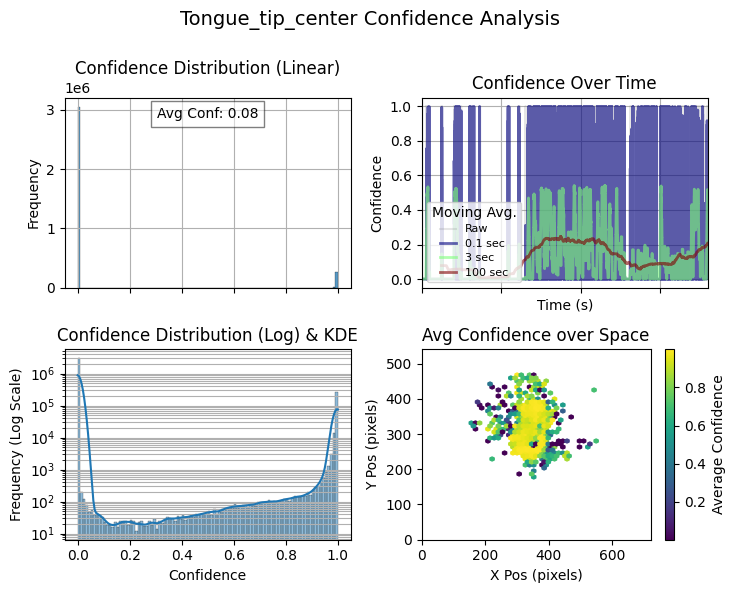

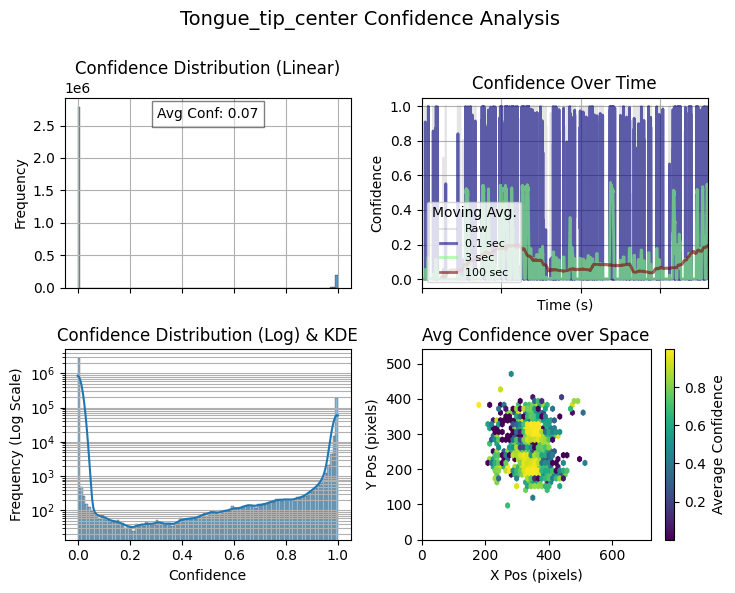

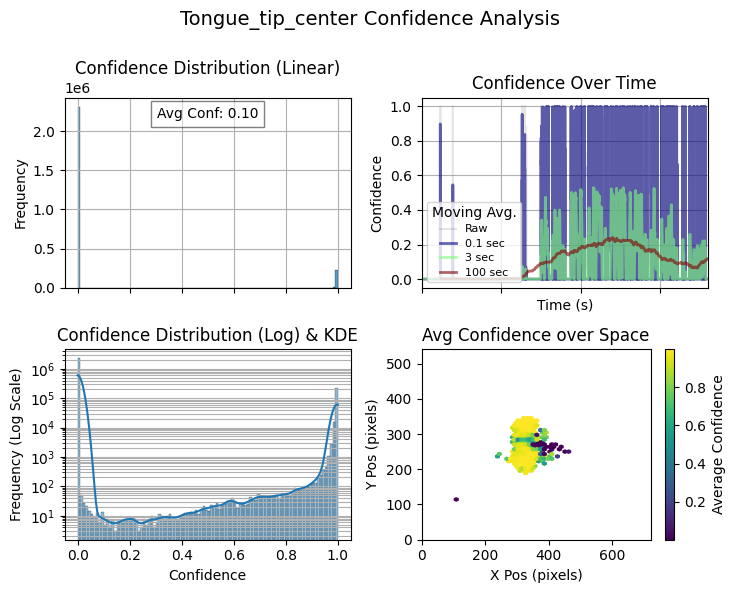

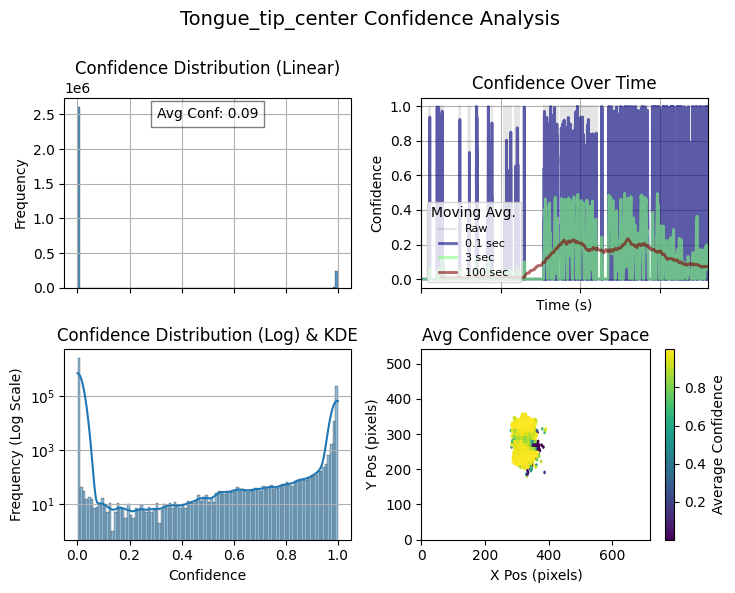

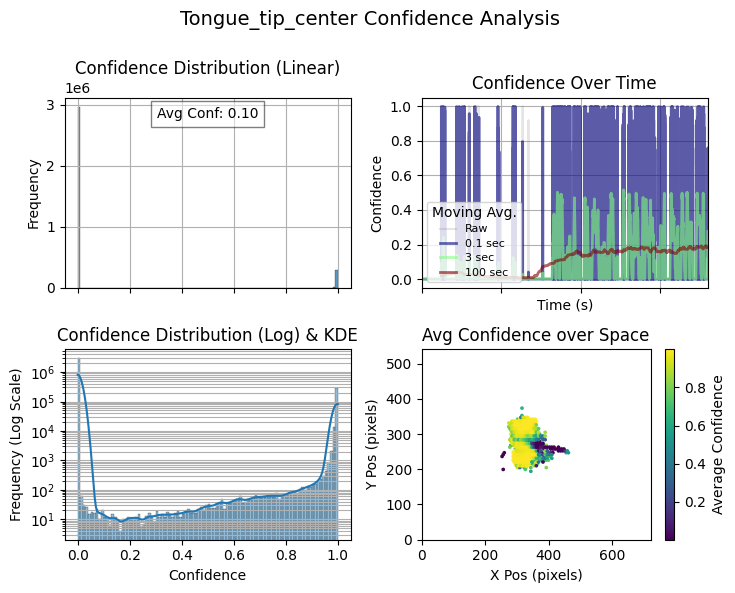

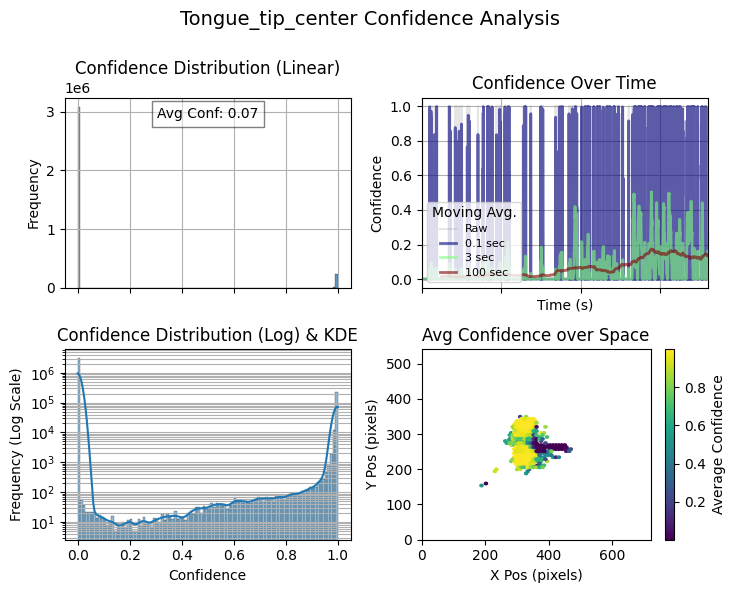

In [7]:
save_root = "/root/capsule/scratch/session_analysis_in_distribution"
data_root = Path("/root/capsule/data")

pred_csv_list = [
    "/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_716325_2024-05-31_10-31-14/bottom_camera.csv",
    "/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_717121_2024-06-15_10-00-58/bottom_camera.csv",
    "/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_717259_2024-06-28_11-17-19/bottom_camera.csv",
    "/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_717263_2024-07-24_10-40-05/bottom_camera.csv",
    "/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_751004_2024-12-20_13-26-07/bottom_camera.csv",
    "/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_751004_2024-12-21_13-28-24/bottom_camera.csv",
    "/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_751004_2024-12-22_13-09-11/bottom_camera.csv",
    "/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_751004_2024-12-23_14-19-57/bottom_camera.csv"
]

run_batch_analysis(pred_csv_list, data_root, save_root)



🔹 Starting analysis for: behavior_751004_2024-12-23_14-19-57

=== Generating tongue data for session: behavior_751004_2024-12-23_14-19-57 ===
Predictions CSV: /root/capsule/data/behavior_751004_2024-12-23_14-19-57_processed_2025-07-10_06-34-56/pred_outputs/video_preds/bottom_camera_predictions.csv
keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Loaded keypoints: 11 raw dataframes
Found video CSV: /root/capsule/data/behavior_751004_2024-12-23_14-19-57/behavior-videos/bottom_camera.csv
Video QC: Frame numbers are sequential with no gaps.
Video QC: Timing differences are within expected range.
keypoint_df trimmed from 3338382 to 3338381
Synced keypoints
Segmented 5817 unique movements
NWB file not found for 751004 on 2024-12-23. Generating it now...
Generated NWB file: /root/capsule/scratch/behavior_751004_2024-12-23_14-19-57/751004_2024-12-23_1

/opt/conda/lib/python3.9/site-packages/aind_dynamic_foraging_data_utils/nwb_utils.py:506: UserWarning: Reward before choice time.                 This is likely due to manual rewards not being recorded in sessions from 2024
  warnings.warn("Reward before choice time. \


NWB load: 579 trials, 5397 licks
Annotated kinematics with trials & licks
Aggregated movements DF shape: (5817, 37)
Analyzing session: behavior_751004_2024-12-23_14-19-57
✅ Finished analysis for behavior_751004_2024-12-23_14-19-57. Results saved to /root/capsule/scratch/session_analysis/behavior_751004_2024-12-23_14-19-57

🔹 Starting analysis for: behavior_751766_2025-02-11_11-53-32

=== Generating tongue data for session: behavior_751766_2025-02-11_11-53-32 ===
Predictions CSV: /root/capsule/data/behavior_751766_2025-02-11_11-53-32_videoprocessed_2025-07-17/pred_outputs/video_preds/bottom_camera_predictions.csv
keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Loaded keypoints: 11 raw dataframes
Found video CSV: /root/capsule/data/behavior_751766_2025-02-11_11-53-32/behavior-videos/bottom_camera.csv
Video QC: Frame numbers are sequential with n

/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
NWB load: 443 trials, 4299 licks
Annotated kinematics with trials & licks
Aggregated movements DF shape: (5194, 37)
Analyzing session: behavior_751766_2025-02-11_11-53-32
✅ Finished analysis for behavior_751766_2025-02-11_11-53-32. Results saved to /root/capsule/scratch/session_analysis/behavior_751766_2025-02-11_11-53-32

🔹 Starting analysis for: behavior_754897_2025-03-11_12-07-35

=== Generating tongue data for session: behavior_754897_2025-03-11_12-07-35 ===
Predictions CSV: /root/capsule/data/behavior_754897_2025-03-11_12-07-35_videoprocessed_2025-07-08/pred_outputs/video_preds/bottom_camera_predictions.csv
keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Loaded keypoints:

/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
NWB load: 564 trials, 4683 licks
Annotated kinematics with trials & licks
Aggregated movements DF shape: (4613, 37)
Analyzing session: behavior_754897_2025-03-13_11-20-39
✅ Finished analysis for behavior_754897_2025-03-13_11-20-39. Results saved to /root/capsule/scratch/session_analysis/behavior_754897_2025-03-13_11-20-39

🔹 Starting analysis for: behavior_758017_2025-02-04_11-57-33

=== Generating tongue data for session: behavior_758017_2025-02-04_11-57-33 ===
Predictions CSV: /root/capsule/data/behavior_758017_2025-02-04_11-57-33_videoprocessed_2025-07-17/pred_outputs/video_preds/bottom_camera_predictions.csv
keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Loaded keypoints:

/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
NWB load: 341 trials, 3949 licks
❌ Error in behavior_758017_2025-02-04_11-57-33: ValueError('left keys must be sorted')

🔹 Starting analysis for: behavior_761038_2025-04-15_10-24-57

=== Generating tongue data for session: behavior_761038_2025-04-15_10-24-57 ===
Predictions CSV: /root/capsule/data/behavior_761038_2025-04-15_10-24-57_videoprocessed_2025-07-17/pred_outputs/video_preds/bottom_camera_predictions.csv
keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Loaded keypoints: 11 raw dataframes
Found video CSV: /root/capsule/data/behavior_761038_2025-04-15_10-24-57/behavior-videos/bottom_camera.csv
Video QC: Frame numbers are sequential with no gaps.
Video QC: Timing differenc

/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
NWB load: 207 trials, 2028 licks
Annotated kinematics with trials & licks
Aggregated movements DF shape: (6151, 37)
Analyzing session: behavior_761038_2025-04-15_10-24-57
✅ Finished analysis for behavior_761038_2025-04-15_10-24-57. Results saved to /root/capsule/scratch/session_analysis/behavior_761038_2025-04-15_10-24-57

🔹 Starting analysis for: behavior_782394_2025-04-24_12-07-31

=== Generating tongue data for session: behavior_782394_2025-04-24_12-07-31 ===
Predictions CSV: /root/capsule/data/behavior_782394_2025-04-24_12-07-31_videoprocessed_2025-07-17/pred_outputs/video_preds/bottom_camera_predictions.csv
keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Loaded keypoints:

/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
❌ Error in behavior_782394_2025-04-24_12-07-31: AssertionError('Reward before choice time')

⚠️ Completed with errors. See log: /root/capsule/scratch/session_analysis/batch_error_log.txt


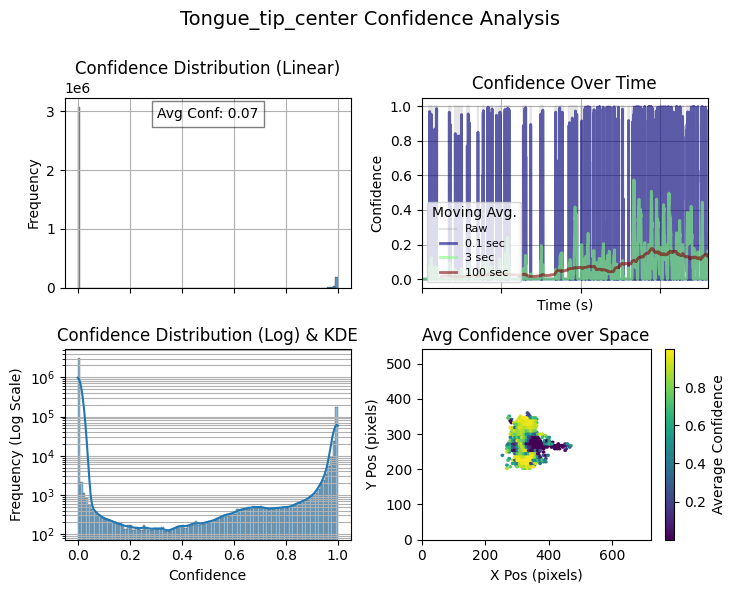

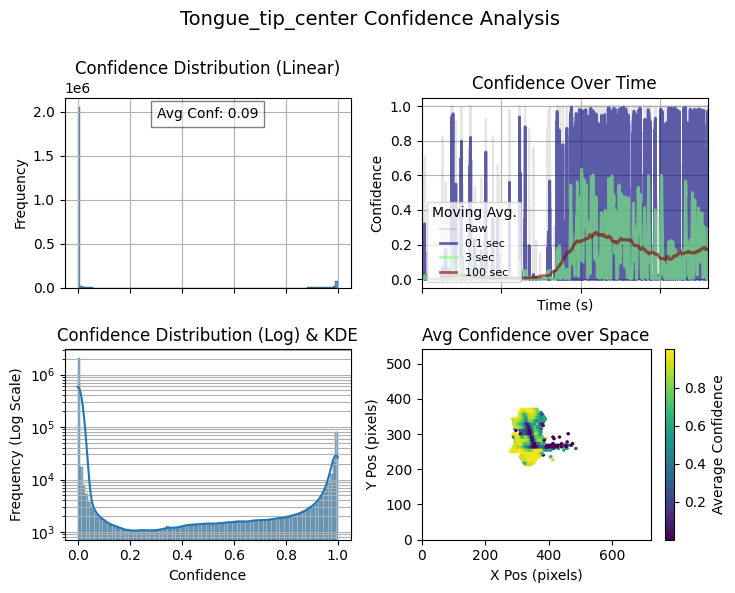

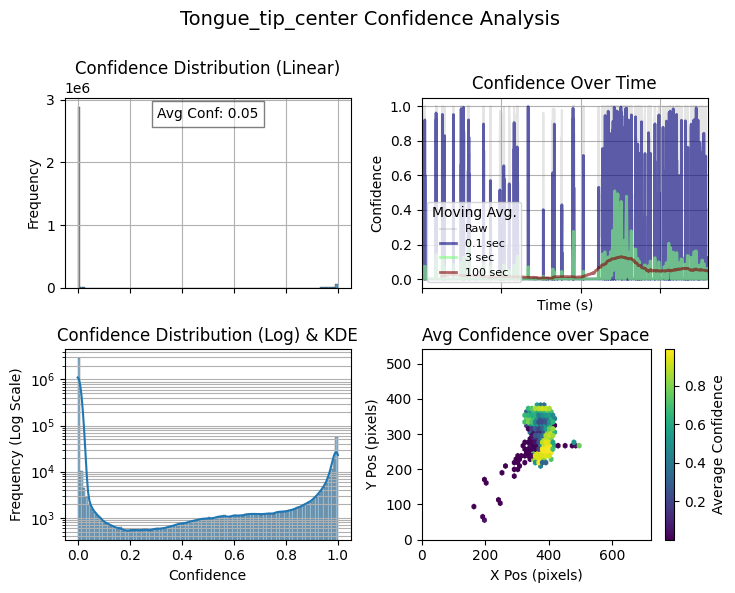

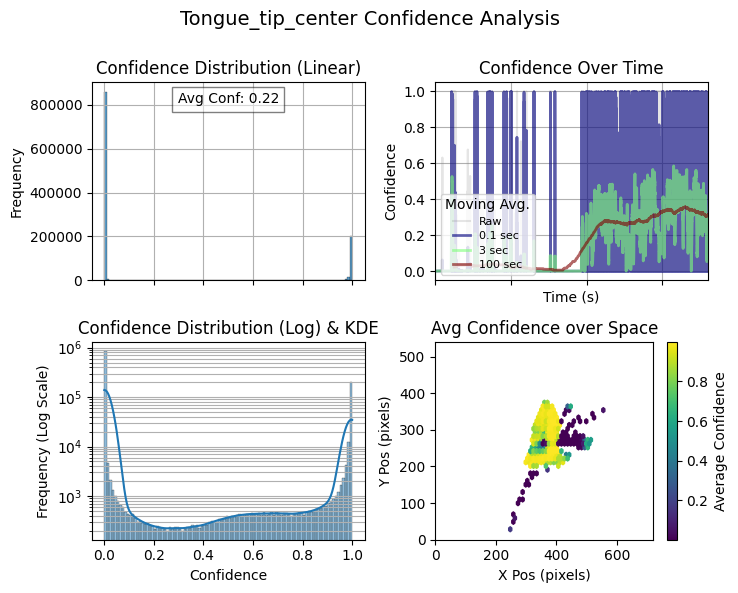

In [6]:
save_root = "/root/capsule/scratch/session_analysis"
data_root = Path("/root/capsule/data")

pred_csv_list = [
    "/root/capsule/data/behavior_751004_2024-12-23_14-19-57_processed_2025-07-10_06-34-56/pred_outputs/video_preds/bottom_camera_predictions.csv",
    "/root/capsule/data/behavior_751766_2025-02-11_11-53-32_videoprocessed_2025-07-17/pred_outputs/video_preds/bottom_camera_predictions.csv",
    "/root/capsule/data/behavior_754897_2025-03-11_12-07-35_videoprocessed_2025-07-08/pred_outputs/video_preds/bottom_camera_predictions.csv",
    "/root/capsule/data/behavior_754897_2025-03-13_11-20-39_videoprocessed_2025-07-17/pred_outputs/video_preds/bottom_camera_predictions.csv",
    "/root/capsule/data/behavior_758017_2025-02-04_11-57-33_videoprocessed_2025-07-17/pred_outputs/video_preds/bottom_camera_predictions.csv",
    "/root/capsule/data/behavior_761038_2025-04-15_10-24-57_videoprocessed_2025-07-17/pred_outputs/video_preds/bottom_camera_predictions.csv",
    "/root/capsule/data/behavior_782394_2025-04-24_12-07-31_videoprocessed_2025-07-17/pred_outputs/video_preds/bottom_camera_predictions.csv"
]

run_batch_analysis(pred_csv_list, data_root, save_root)


In [12]:
#test single session on batch analysis

save_root = "/root/capsule/scratch/session_analysis" #update save location as needed
data_root = Path("/root/capsule/data")

pred_csv_list = [
    "/root/capsule/data/behavior_754897_2025-03-11_12-07-35_videoprocessed_2025-07-08/pred_outputs/video_preds/bottom_camera_predictions.csv"
]

run_batch_analysis(pred_csv_list, data_root, save_root)


🔹 Starting analysis for: behavior_754897_2025-03-11_12-07-35

=== Generating tongue data for session: behavior_754897_2025-03-11_12-07-35 ===
Predictions CSV: /root/capsule/data/behavior_754897_2025-03-11_12-07-35_videoprocessed_2025-07-08/pred_outputs/video_preds/bottom_camera_predictions.csv
keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Loaded keypoints: 11 raw dataframes
Found video CSV: /root/capsule/data/behavior_754897_2025-03-11_12-07-35/behavior-videos/bottom_camera.csv
Video QC: Frame numbers are sequential with no gaps.
Video QC: Timing differences are within expected range.
keypoint_df trimmed from 2080516 to 2080515
Synced keypoints
Segmented 3216 unique movements
Loading NWB from /root/capsule/data/foraging_nwb_bonsai/754897_2025-03-11_11-45-10.nwb


/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
❌ Error in behavior_754897_2025-03-11_12-07-35: AssertionError('Rewarded trials without reward time')

⚠️ Completed with errors. See log: /root/capsule/scratch/session_analysis/batch_error_log.txt


In [10]:
# look into individual session for errors when generating dfs


data_root = Path("/root/capsule/data")

pred_csv = "/root/capsule/data/behavior_754897_2025-03-11_12-07-35_videoprocessed_2025-07-08/pred_outputs/video_preds/bottom_camera_predictions.csv"
session_id = get_session_name_from_path(str(pred_csv))

# ---- 1) Generate DFs ----
nwb, tongue_kins, tongue_movs, kps_raw = generate_tongue_dfs(pred_csv, data_root)


=== Generating tongue data for session: behavior_754897_2025-03-11_12-07-35 ===
Predictions CSV: /root/capsule/data/behavior_754897_2025-03-11_12-07-35_videoprocessed_2025-07-08/pred_outputs/video_preds/bottom_camera_predictions.csv
keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Loaded keypoints: 11 raw dataframes
Found video CSV: /root/capsule/data/behavior_754897_2025-03-11_12-07-35/behavior-videos/bottom_camera.csv
Video QC: Frame numbers are sequential with no gaps.
Video QC: Timing differences are within expected range.
keypoint_df trimmed from 2080516 to 2080515
Synced keypoints
Segmented 3216 unique movements
Loading NWB from /root/capsule/data/foraging_nwb_bonsai/754897_2025-03-11_11-45-10.nwb


/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


Timestamps are adjusted such that `_in_session` timestamps start at the first go cue


AssertionError: Rewarded trials without reward time

> /opt/conda/lib/python3.9/site-packages/aind_dynamic_foraging_data_utils/nwb_utils.py(497)create_df_trials()
    495                 This is likely due to manual rewards not being recorded in sessions from 2024")
    496         else:
--> 497             raise AssertionError("Rewarded trials without reward time")
    498 
    499     assert (

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


In [3]:
# look into individual session for errors when generating dfs

data_root = Path("/root/capsule/data")

pred_csv = "/root/capsule/data/behavior_758017_2025-02-04_11-57-33_videoprocessed_2025-07-17/pred_outputs/video_preds/bottom_camera_predictions.csv"
session_id = get_session_name_from_path(str(pred_csv))

# ---- 1) Generate DFs ----
nwb, tongue_kins, tongue_movs, kps_raw = generate_tongue_dfs(pred_csv, data_root)



NameError: name 'Path' is not defined

> /tmp/ipykernel_29163/3080672345.py(3)<module>()
      1 # look into individual session for errors when generating dfs
      2 
----> 3 data_root = Path("/root/capsule/data")
      4 
      5 pred_csv = "/root/capsule/data/behavior_758017_2025-02-04_11-57-33_videoprocessed_2025-07-17/pred_outputs/video_preds/bottom_camera_predictions.csv"

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


In [9]:
%pdb on

Automatic pdb calling has been turned ON


In [ ]:
# look into individual session for errors when generating dfs


data_root = Path("/root/capsule/data")

pred_csv = "/root/capsule/data/behavior_782394_2025-04-24_12-07-31_videoprocessed_2025-07-17/pred_outputs/video_preds/bottom_camera_predictions.csv"
session_id = get_session_name_from_path(str(pred_csv))

# ---- 1) Generate DFs ----
nwb, tongue_kins, tongue_movs, kps_raw = generate_tongue_dfs(pred_csv, data_root)

In [ ]:
# #script version

# from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import get_session_name_from_path

# session_id = get_session_name_from_path(str(pred_csv))

# # --- coverage calculations ---
# total_licks = len(nwb.df_licks)
# with_mov = nwb.df_licks['nearest_movement_id'].notna().sum()
# coverage_pct = 100 * with_mov / total_licks if total_licks else np.nan

# lick_movs = tongue_movs[tongue_movs['has_lick']]
# lick_times = nwb.df_licks['timestamps']  # or time_in_session
# has_mov = nwb.df_licks['nearest_movement_id'].notna()
# covered_times = lick_times[has_mov]
# missed_times = lick_times[~has_mov]

# # --- FIGURE 1 ---
# fig = plt.figure(constrained_layout=True, figsize=(14, 8))
# parent_gs = fig.add_gridspec(2, 1, height_ratios=[1, 1])  # top row, bottom row

# # Top row: skinny coverage, wide raster, scatter
# gs_top = parent_gs[0].subgridspec(1, 4, width_ratios=[0.5, 2.5, 2.0, 2.0])
# gs_top = parent_gs[0].subgridspec(1, 3, width_ratios=[0.5, 6, 3])


# # Bottom row: 3 equal-width histograms
# gs_bottom = parent_gs[1].subgridspec(1, 3, width_ratios=[1, 1, 1])

# # --- AXES ---
# ax_cov = fig.add_subplot(gs_top[0, 0])
# ax_raster = fig.add_subplot(gs_top[0, 1])
# ax_scat = fig.add_subplot(gs_top[0, 2])
# ax_h0 = fig.add_subplot(gs_bottom[0, 0])
# ax_h1 = fig.add_subplot(gs_bottom[0, 1])
# ax_h2 = fig.add_subplot(gs_bottom[0, 2])

# # --- COVERAGE BAR (stacked, with n in legend) ---
# n_missed = total_licks - with_mov
# ax_cov.bar(0, coverage_pct, color='green', label=f'Covered (n={with_mov})')
# ax_cov.bar(0, 100 - coverage_pct, bottom=coverage_pct,
#            color='red', label=f'Missed (n={n_missed})')

# ax_cov.set_ylim(0, 100)
# ax_cov.set_xlim(-0.5, 0.5)
# ax_cov.set_xticks([])
# ax_cov.set_yticks([0, 50, 100])
# ax_cov.set_ylabel('percentage')
# ax_cov.set_title("Lick Coverage (%)", fontsize=10)
# ax_cov.legend(fontsize=7, loc='lower center')


# # --- RASTER ---
# ax_raster.eventplot(
#     [covered_times, missed_times],
#     lineoffsets=[1, 0], linelengths=0.8,
#     colors=['green', 'red']
# )
# ax_raster.set_yticks([1, 0])
# ax_raster.set_yticklabels(['Covered', 'Missed'])
# ax_raster.set_xlabel('Time in session (s)')
# ax_raster.set_title(f'Lick coverage over session')

# # --- SCATTER ---
# ax_scat.scatter(lick_movs['duration'], lick_movs['dropped_frames_pct'],
#                 alpha=0.05, edgecolor='k')
# ax_scat.set_xlabel('Duration (s)')
# ax_scat.set_ylabel('Dropped Frame %')
# ax_scat.set_title('Duration vs Drop%')

# # --- HISTOGRAMS ---
# ax_h0.hist(lick_movs['n_datapoints'], bins=30)
# ax_h0.set(title='Datapoints', xlabel='number of datapoints in movement', ylabel='count')

# ax_h1.hist(lick_movs['duration'], bins=30)
# ax_h1.set(title='Duration', xlabel='duration of movement (s)')

# ax_h2.hist(lick_movs['dropped_frames_pct'], bins=30)
# ax_h2.set(title='Dropped %', xlabel='percentage dropped frames (%)')

# plt.suptitle(f'{session_id}', y=1.05)

# plt.show()


# # --- FIGURE 2 and 3: EXAMPLE MOVEMENTS ---

# # relative time for plotting example movements
# tongue_kins['time_in_movement'] = (
#     tongue_kins['time'] - 
#     tongue_kins.groupby('movement_id')['time'].transform('first')
# )




# percentiles=[0,.1,.25,.5,.75,.9,1]

# metric_col = 'dropped_frames_n'
# sel = select_percentile_movements(tongue_movs, metric_col=metric_col,percentiles=percentiles)
# labels = [f"{int(p*100)}%ile: {val:.2f}" 
#           for p, val in zip(sel['percentile'], sel[metric_col])]
# plot_movement_tiles_scatter(
#     tongue_segmented=tongue_kins,
#     movement_ids=sel['movement_id'].tolist(),
#     x_col='time_in_movement',
#     y_col='x',
#     labels=labels,
#     color='gray',
#     title=metric_col
# )


# metric_col = 'duration'
# sel = select_percentile_movements(tongue_movs, metric_col=metric_col,percentiles=percentiles)
# labels = [f"{int(p*100)}%ile: {val:.2f}" 
#           for p, val in zip(sel['percentile'], sel[metric_col])]

# plot_movement_tiles_scatter(
#     tongue_segmented=tongue_kins,
#     movement_ids=sel['movement_id'].tolist(),
#     x_col='time_in_movement',
#     y_col='x',
#     labels=labels,
#     color='gray',
#     title=metric_col
# )



In [ ]:
# percentiles=[0,.1,.25,.5,.75,.9,1]

# metric_col = 'dropped_frames_n'
# sel = select_percentile_movements(tongue_movs, metric_col=metric_col,percentiles=percentiles)
# labels = [f"{int(p*100)}%ile: {val:.2f}" 
#           for p, val in zip(sel['percentile'], sel[metric_col])]
# plot_movement_tiles_scatter(
#     tongue_segmented=tongue_kins,
#     movement_ids=sel['movement_id'].tolist(),
#     x_col='time_in_movement',
#     y_col='x',
#     labels=labels,
#     color='gray',
#     title=metric_col
# )


# metric_col = 'duration'
# sel = select_percentile_movements(tongue_movs, metric_col=metric_col,percentiles=percentiles)
# labels = [f"{int(p*100)}%ile: {val:.2f}" 
#           for p, val in zip(sel['percentile'], sel[metric_col])]

# plot_movement_tiles_scatter(
#     tongue_segmented=tongue_kins,
#     movement_ids=sel['movement_id'].tolist(),
#     x_col='time_in_movement',
#     y_col='x',
#     labels=labels,
#     color='gray',
#     title=metric_col
# )

